In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import time
from scipy import ndimage


'''
Below we include some functions used for data processing. 
Please kindly follow citation suggestions in the README.md is you use below code in your research.
'''

def PlotGantry(bg_img, angles, x, y, length, width = 4):

    angles = [angle - 90 for angle in angles]
    
    points = [(int(x + length * np.cos(np.pi / 180 * float(angle))), int(y + length * np.sin(np.pi / 180 * float(angle)))) for angle in angles]
    for point in points:
        cv2.line(bg_img, point, (x, y), (1), width)
    return bg_img

def interpolate_point_on_line(x1, y1, z1, x2, y2, z2, y_c):
    """
    Returns the coordinates of point C on the line segment from (x1, y1, z1) to (x2, y2, z2)
    with the specified y-coordinate y_c.
    """
    # Calculate the ratio of y_c relative to the total y-distance between points A and B

    if y2 == y1:
        y2 += 1
    ratio = (y_c - y1) / (y2 - y1)
    
    # Use linear interpolation to find the corresponding x and z coordinates
    x_c = x1 + ratio * (x2 - x1)
    z_c = z1 + ratio * (z2 - z1)
    
    return int(x_c), int(y_c), int(z_c)


def interpolate_line(x1, y1, z1, x2, y2, z2, y_c):
    """
    Returns all the coordinates along the line segment from (x1, y1, z1) to (x2, y2, z2).
    """
    # Calculate the distance between the points

    x_c, y_c, z_c = interpolate_point_on_line(x1, y1, z1, x2, y2, z2, y_c)

    length = max(abs(x_c - x1), abs(y_c - y1), abs(z_c - z1))
    
    # Generate linearly spaced coordinates between the points
    x_coords = np.linspace(x1, x_c, length + 1)
    y_coords = np.linspace(y1, y_c, length + 1)
    z_coords = np.linspace(z1, z_c, length + 1)
    
    # Round coordinates to integers
    x_coords = np.round(x_coords).astype(int)
    y_coords = np.round(y_coords).astype(int)
    z_coords = np.round(z_coords).astype(int)
    
    # Combine coordinates into tuples
    coordinates = [(x, y, z) for x, y, z in zip(x_coords, y_coords, z_coords)]
    
    return coordinates


def get_source_from_angle(isocenter, angle, space):
    angle = angle - 90 
    
    points =  isocenter[0], int(isocenter[1] + 1000 * np.sin(np.pi / 180 * float(angle)) / space[1]), int(isocenter[2] + 1000 * np.cos(np.pi / 180 * float(angle)) / space[2])
    return points

def get_nonzero_coordinates(binary_mask):
    """
    Returns the coordinates of non-zero values in a binary mask.
    """
    nonzero_coords = np.transpose(np.nonzero(binary_mask))
    return [tuple(coord) for coord in nonzero_coords]

def surface_coordinates(binary_mask):
    nonzero_coords = get_nonzero_coordinates(binary_mask)
    surface_coords = []
    for coord in nonzero_coords:
        x, y, z = coord
        if (binary_mask[x-1, y, z] == 0 or
            binary_mask[x+1, y, z] == 0 or
            binary_mask[x, y-1, z] == 0 or
            binary_mask[x, y+1, z] == 0 or
            binary_mask[x, y, z-1] == 0 or
            binary_mask[x, y, z+1] == 0):
            surface_coords.append((x, y, z))  
    return surface_coords

def get_per_beamplate(PTV_mask, isocenter, space, gantry_angle, with_distance = True):
    
    # PTV_mask (z, x, y), sicenter = (z, x, y), space = (z, x, y), gantry_angle = float

    source = get_source_from_angle(isocenter, gantry_angle, space)
    #print ('source', source)


    surface_coords = surface_coordinates(PTV_mask)
    #print (time.time() - start)

    all_points = []
    for point in surface_coords:
        if source[1] > point[1]:
            y_c = 0
        else:
            y_c = PTV_mask.shape[1] - 1
        path = interpolate_line(source[0], source[1], source[2], point[0], point[1], point[2], y_c = y_c)
        all_points.extend(path)
    #print (time.time() - start)

    beam_plate = np.zeros_like(PTV_mask).astype(np.uint8)
    for item in set(all_points):
        if item[0] >= 0 and item[0] < PTV_mask.shape[0] and item[1] >= 0 and item[1] < PTV_mask.shape[1] and item[2] >= 0 and item[2] < PTV_mask.shape[2]:
            beam_plate[item[0], item[1], item[2]] = 1
    #print (time.time() - start)
    beam_plate = ndimage.binary_dilation(beam_plate, structure=np.ones((4,4,4))) #.astype(PTV_mask.dtype)
    beam_plate = ndimage.binary_erosion(beam_plate, structure=np.ones((3,3,3))) #.astype(PTV_mask.dtype)

    #print (time.time() - start)

    if with_distance:
        x_indices = np.arange(beam_plate.shape[0])
        y_indices = np.arange(beam_plate.shape[1])
        z_indices = np.arange(beam_plate.shape[2])

        x_coords, y_coords, z_coords = np.meshgrid(x_indices, y_indices, z_indices, indexing='ij')

        # Compute distances using broadcasting
        distances = (x_coords - source[0])**2 + (y_coords - source[1])**2 + (z_coords - source[2])**2

        r_dis = ((source[0] - isocenter[0]) ** 2 + (source[1] - isocenter[1]) ** 2 + (source[2] - isocenter[2]) ** 2) / distances 
        beam_plate = beam_plate * r_dis
        #print (time.time() - start)

    return beam_plate

def get_allbeam_plate(PTV_mask, isocenter, space, angles, with_distance = True):
    all_beam_plate = np.zeros_like(PTV_mask).astype('float')
    for angle in angles:
        all_beam_plate += get_per_beamplate(PTV_mask, isocenter, space, angle, with_distance = with_distance)
    return all_beam_plate




In [2]:
data_path = 'data/0617-259694+imrt+MOS_33896.npz'
data_npz = np.load(data_path, allow_pickle=True)
data_dict = dict(data_npz)['arr_0'].item()
print (data_dict.keys())


dict_keys(['50per_Ring1.5-5', 'Body', 'Body_Ring0-3', 'BrachialPlexus', 'CTV', 'Esophagus', 'GTV', 'GreatVessels', 'Heart', 'LAD', 'Lung_Cntr', 'Lung_Ipsi', 'Lung_Total', 'PTV', 'PTV_Ring.3-2', 'SpinalCord', 'SpinalCord_05', 'Total Lung-GTV', 'Trachea', 'all_mask', 'img', 'dose', 'dose_scale', 'isVMAT', 'angle_plate', 'isocenter', 'angle_list', 'origin', 'spacing', 'direction', 'size', 'beam_plate'])


(96, 100, 151) [48.0, 64.0, 55.0]


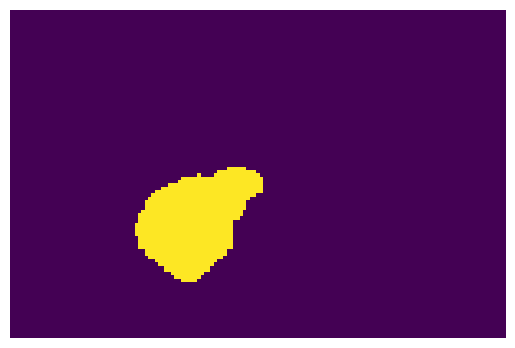

In [12]:
print (data_dict['PTV'].shape, data_dict['isocenter'])
save_fig = True

plt.tight_layout(pad=0)
plt.imshow(data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/PTV.png', bbox_inches='tight', pad_inches=0)



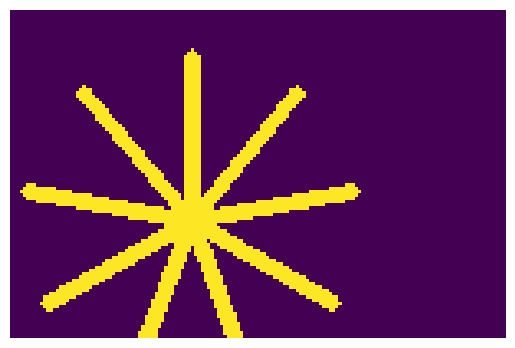

In [13]:

angle_plate = PlotGantry(bg_img = np.zeros_like(data_dict['PTV'][0]), 
                         angles = data_dict['angle_list'], 
                         x = int(data_dict['isocenter'][2]), 
                         y = int(data_dict['isocenter'][1]),
                        length =  50,
                         width = 4)
plt.imshow(angle_plate)

if save_fig:
    plt.axis('off')
    plt.savefig('figs/angle_plate.png', bbox_inches='tight', pad_inches=0)

In [67]:
print (data_dict['angle_list'])

[  0. 160. 280. 320.  40. 200.  80. 240. 120.]


the beam angle is: 0.0


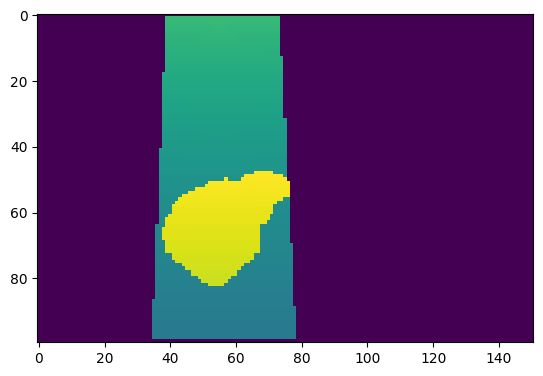

In [68]:
all_beam_plate = []

beam_plate1 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                 [2, 2.5, 2.5], data_dict['angle_list'][0], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][0])

plt.imshow(beam_plate1[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate1.png', bbox_inches='tight', pad_inches=0)



the beam angle is: 160.0


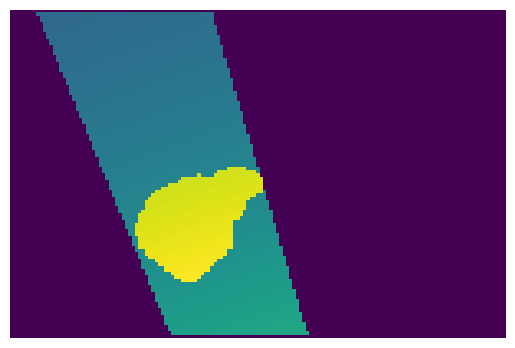

In [14]:
beam_plate2 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                [2, 2.5, 2.5], data_dict['angle_list'][1], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][1])

plt.imshow(beam_plate2[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate2.png', bbox_inches='tight', pad_inches=0)

the beam angle is: 280.0


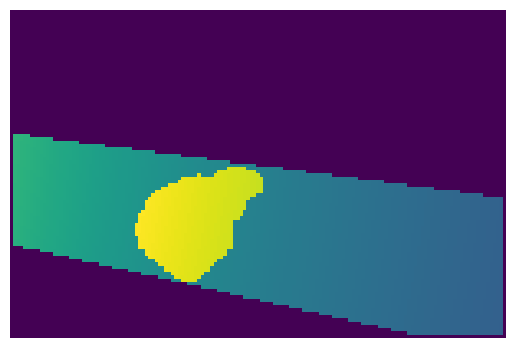

In [15]:
beam_plate3 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                    [2, 2.5, 2.5], data_dict['angle_list'][2], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][2])

plt.imshow(beam_plate3[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate3.png', bbox_inches='tight', pad_inches=0)

the beam angle is: 320.0


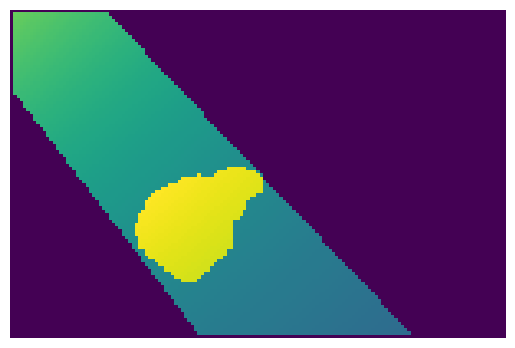

In [17]:
beam_plate4 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                    [2, 2.5, 2.5], data_dict['angle_list'][3], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][3])

plt.imshow(beam_plate4[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate4.png', bbox_inches='tight', pad_inches=0)

the beam angle is: 40.0


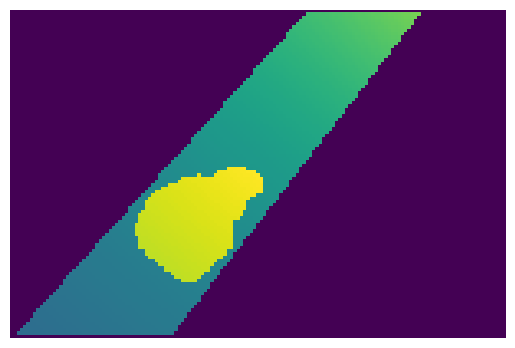

In [18]:
beam_plate5 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                    [2, 2.5, 2.5], data_dict['angle_list'][4], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][4])

plt.imshow(beam_plate5[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate5.png', bbox_inches='tight', pad_inches=0)


the beam angle is: 200.0


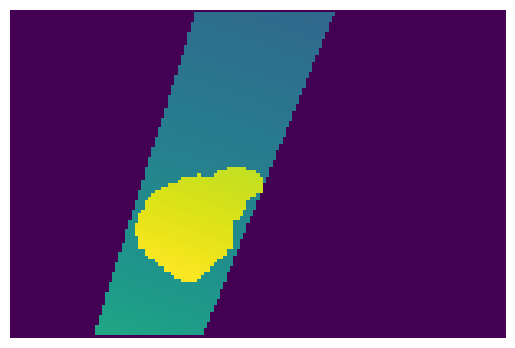

In [19]:
beam_plate6 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                    [2, 2.5, 2.5], data_dict['angle_list'][5], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][5])

plt.imshow(beam_plate6[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate6.png', bbox_inches='tight', pad_inches=0)

the beam angle is: 80.0


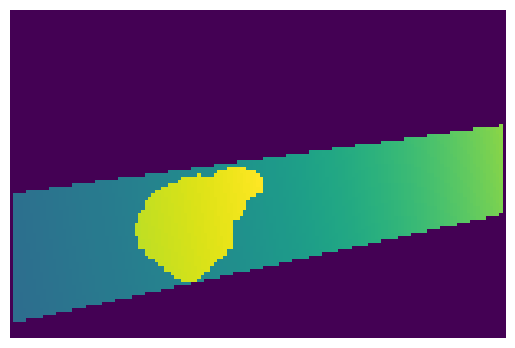

In [20]:
beam_plate7 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                    [2, 2.5, 2.5], data_dict['angle_list'][6], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][6])    

plt.imshow(beam_plate7[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate7.png', bbox_inches='tight', pad_inches=0)

the beam angle is: 240.0


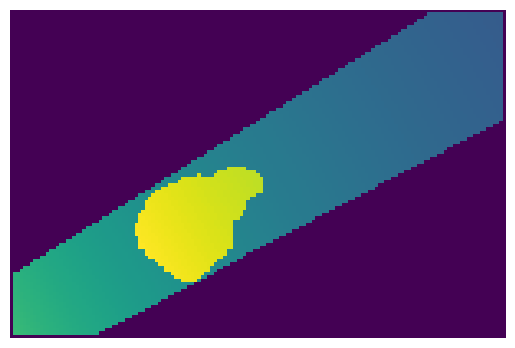

In [21]:
beam_plate8 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                    [2, 2.5, 2.5], data_dict['angle_list'][7], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][7])
plt.imshow(beam_plate8[48] + data_dict['PTV'][48])  

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate8.png', bbox_inches='tight', pad_inches=0)

the beam angle is: 120.0


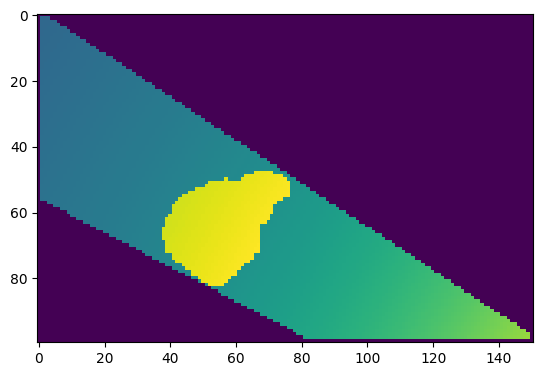

In [76]:
beam_plate9 = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'],
                                    [2, 2.5, 2.5], data_dict['angle_list'][8], with_distance = True).astype('float')
print ('the beam angle is:', data_dict['angle_list'][8])
plt.imshow(beam_plate9[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/beam_plate9.png', bbox_inches='tight', pad_inches=0)

In [23]:
final_beam_plate = np.zeros_like(data_dict['PTV']).astype('float32')

for i in range(len(data_dict['angle_list'])):
    gantry_angle = data_dict['angle_list'][i]
    
    tmp_plate = get_per_beamplate(data_dict['PTV'].copy(), data_dict['isocenter'], [2, 2.5, 2.5], gantry_angle).astype('float32')
    final_beam_plate += tmp_plate

    

0.0


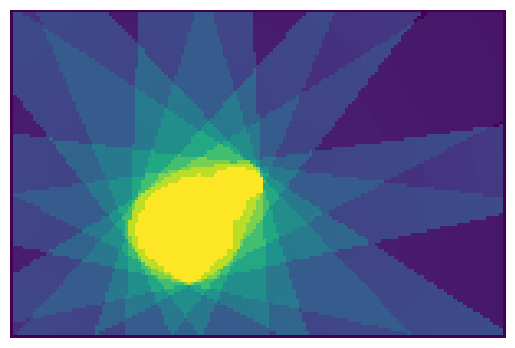

In [24]:
print (np.sum(np.abs(final_beam_plate - data_dict['beam_plate'])))
plt.imshow(final_beam_plate[48] + data_dict['PTV'][48])

if save_fig:
    plt.axis('off')
    plt.savefig('figs/final_beam_plate.png', bbox_inches='tight', pad_inches=0)